In [1]:
!pip install matplotlib

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('/app/ws/trifinger_rl_datasets'))
sys.path.insert(0, module_path)
module_path = os.path.abspath(os.path.join('/app/ws/trifinger-rl-example'))
sys.path.insert(0, module_path)
module_path = os.path.abspath(os.path.join('/app/ws/google-research'))
sys.path.insert(0, module_path)

In [3]:
import trifinger_rl_datasets
import gymnasium as gym

# set torch an numpy seed
import numpy as np
import tensorflow as tf
import torch

pybullet build time: May 20 2022 19:44:17
2023-07-06 09:50:06.451858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 09:50:07.308026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# this can be changed to any other environment in the trifinger gym
# see https://webdav.tuebingen.mpg.de/trifinger-rl/docs/datasets/index.html
# However, if real robot data is used, no monte carlo sampling is possible 
# Since real-env does not support simulation
env_name = "trifinger-cube-push-sim-mixed-v0"
normalize_states = True
normalize_rewards = True
seed = 0

# this noise is applied to the rewards, there is a seperate paper 
# on this improving the performance https://arxiv.org/pdf/2007.13609.pdf
noise_scale = 0.0 
bootstrap = False # use bootstraped weights
sample_batch_size = 256


np.random.seed(seed)
torch.manual_seed(seed)
tf.random.set_seed(seed)

In [5]:

gpu_memory = 12209 # GPU memory available on the machine
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Restrict TensorFlow to only allocate 20% of the memory on the first GPU
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(gpu_memory * 0.2))])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e, " GPUs must be set at program startup")



1 Physical GPUs, 1 Logical GPUs


2023-07-06 09:50:09.671268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2441 MB memory:  -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2


In [58]:
env_name = "mixed"
env = gym.make(
    f"trifinger-cube-push-real-{env_name}-v0",
    set_terminals =True,  # necessary since DOPE uses the terminals
    flatten_obs = True,   # obs as dictionary vs as array  
    image_obs = False,    # deactivate fetching images since large amounts of data
    visualization=False,  # enable visualization
)
dataset = env.get_dataset() # pull the dataset
dataset.keys()

/envs/eval/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


100%|██████████████████████| 1/1 [00:12<00:00, 12.34s/it]


Assembling dataset parts.


100%|██████████████████████| 1/1 [00:01<00:00,  1.09s/it]


dict_keys(['observations', 'actions', 'rewards', 'timeouts', 'terminals', 'infos'])

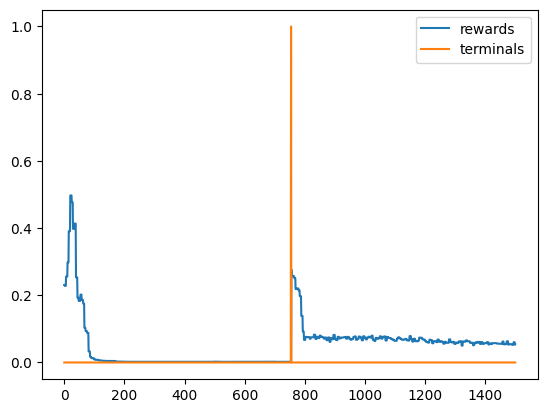

In [59]:
# you can plot data here e.g.
import matplotlib.pyplot as plt
# the rewards are a flattened array and each episode is 750 steps
plt.plot(dataset["rewards"][:750*2]) 
plt.plot(dataset["terminals"][:750*2])
# add legend
plt.legend(["rewards", "terminals"])
plt.show()

In [60]:
# print the first occurence of masks= 0
np.where(dataset["terminals"] == 1)[0][0]
# print all occurences of masks = 0
np.where(dataset["terminals"] == 1)[0]
# split the dataset into episodes based on the masks
episodes = np.split(dataset["rewards"], np.where(dataset["terminals"]== 1)[0]+1)

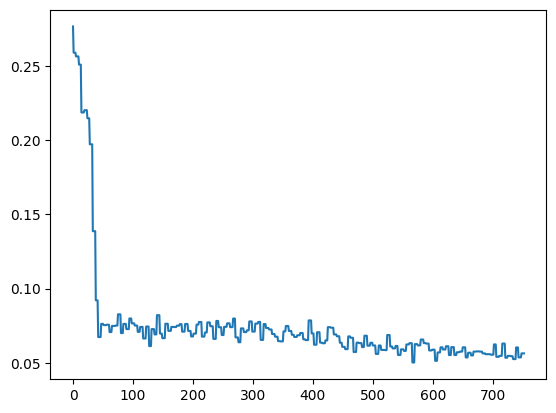

In [61]:
plt.plot()
plt.plot(episodes[1])
plt.show()

In [62]:
# for each episode compute the discounted return
discount = 0.995
discounted_returns = []
for episode in episodes:
    discounted_return = 0
    # with numpy
    discounted_return = np.sum(discount**np.arange(len(episode)) * episode)
    discounted_returns.append(discounted_return)
    

In [69]:
!pwd

/app/ws


In [63]:
import pickle as pkl
with open(f"{env_name}_return.pkl", "wb") as f:
    pkl.dump(discounted_returns, f)

In [64]:
discounted_returns_corr = np.asarray(discounted_returns) * (1-discount)

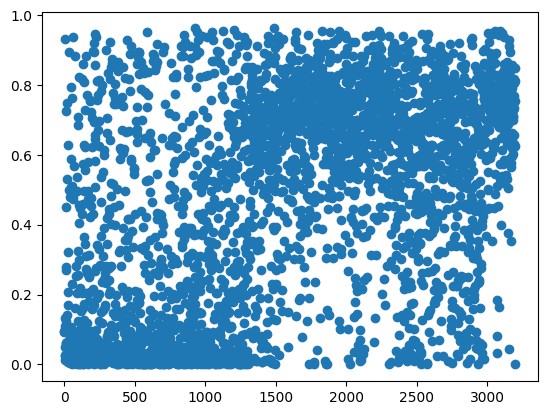

In [65]:
# plot the returns
# as points
plt.plot(discounted_returns_corr, "o")
plt.show()


In [66]:
# calculate the mean discounted return
mean_expert = np.mean(discounted_returns)
std_expert = np.std(discounted_returns)

In [67]:
mean_expert *(1-discount)

0.4640071520155449

In [68]:
std_expert*(1-discount)

0.3081662245012843

In [77]:
print(dataset["infos"][0].keys())

dict_keys([])


In [75]:
print(len(dataset["infos"]))
print(len(dataset["terminals"]))
# print first 10 positions where terminals appear
np.where(dataset["terminals"] == 1)[0][:10]
# count the number of terminals where at the same position dataset["infos"] is ["has_achieved"] ==True
count = 0
for i in np.where(dataset["terminals"] == 1)[0]:
    if dataset["infos"][i]["has_achieved"] == True:
        count +=1
print(count)

2410084
2410084


KeyError: 'has_achieved'

In [ ]:
def count_successes(infos):
    successes = 0
    for i in range(len(infos)):
        if infos[i][len(infos[i])-1]["has_achieved"]==True:
            successes += 1
    return successes

